<a href="https://colab.research.google.com/github/HMCBSJ/Crawling_Engine/blob/main/Recsys_baseline_demo_Chinese210330.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Getting Started: Loading Libraries

In [12]:
import pandas as pd
import numpy as np3
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import jieba

In [14]:
os.getcwd() 
path = "/content/drive/MyDrive/Foxconn_1/Recsys/code"
try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))

Current working directory: /content/drive/MyDrive/Foxconn_1/Recsys/code


#### Loading the Dataset
Loading the Dataset provided by Kaggle <a href = "https://www.kaggle.com/rounakbanik/the-movies-dataset">The Movies Dataset</a> to a Pandas DataFrame

In [15]:
# open a file, where you stored the pickled data
file = open('EPG_per_0102_0321', 'rb')
# dump information to that file
EPG_per_0102_0321 = pickle.load(file)
file = open('EPG_per_0203_0321', 'rb')
# dump information to that file
EPG_per_0203_0321 = pickle.load(file)
file = open('EPG_per_0304_0321', 'rb')
# dump information to that file
EPG_per_0304_0321 = pickle.load(file)
file = open('EPG_per_0405_0321', 'rb')
# dump information to that file
EPG_per_0405_0321 = pickle.load(file)
file = open('EPG_per_0506_0321', 'rb')
# dump information to that file
EPG_per_0506_0321 = pickle.load(file)
file = open('EPG_per_0607_0321', 'rb')
# dump information to that file
EPG_per_0607_0321 = pickle.load(file)
# close the file
file = open('EPG_per_0708_0321', 'rb')
# dump information to that file
EPG_per_0708_0321 = pickle.load(file)
file.close()

### Let's check the amout of dataset

In [69]:
df0 = pd.DataFrame(EPG_per_0102_0321)
df1 = pd.DataFrame(EPG_per_0203_0321)
df2 = pd.DataFrame(EPG_per_0304_0321)
df3 = pd.DataFrame(EPG_per_0405_0321)
df4 = pd.DataFrame(EPG_per_0506_0321)
df5 = pd.DataFrame(EPG_per_0607_0321)
df6 = pd.DataFrame(EPG_per_0708_0321)

frames = [df0, df1, df2, df3, df4, df5, df6]
df = pd.concat(frames)

In [70]:
df.columns = ['ch_nb','ch_nm','title',
                     'genres','keywords','date','time']

df_copy = df.copy(deep=True)
df_copy.head(1)

df_copy[['del','genres']] = df_copy['genres'].str.split('類別',1,expand=True)
del df_copy['del']
df_copy[['genres','cast']] = df_copy['genres'].str.extract('(.*)：(.*)',expand=True)
df_copy[['del2','genres']] = df_copy['genres'].str.extract('(.*)：(.*)',expand=True)
del df_copy['del2']

stop = ['導演']
df_copy['genres'] = df_copy['genres'].apply(lambda x: ' '.join([item for item in str(x).split() if item not in stop]))

df_copy['title'] = df_copy['title'].str.replace('\d+', '') # remove number
df_copy= df_copy.drop_duplicates(subset='title', keep="last") # remove dupluicate rows
print(len(df_copy)) # 27000 -->2724 -->1919

df_copy.head(2)

4261


,ch_nb,ch_nm,title,genres,keywords,date,time,cast
227,13,公共電視,幻愛,nan,個性善良憨厚的小學老師阿樂（劉俊謙 飾），是一名精神分裂症復原者，渴望愛情但從來不敢與人有更...,2021/03/01,00:00~02:00,：亞洲電影 導演
323,16,原住民頻道,族語故事書:,nan,原視新節目「族語故事書」，是一個用族語來說自己故事、說自己文化的動畫節目。用淺顯易懂的方式，...,2021/03/01,01:30~02:00,


In [71]:
df_copy.head(50)

,ch_nb,ch_nm,title,genres,keywords,date,time,cast
227,13,公共電視,幻愛,nan,個性善良憨厚的小學老師阿樂（劉俊謙 飾），是一名精神分裂症復原者，渴望愛情但從來不敢與人有更...,2021/03/01,00:00~02:00,：亞洲電影 導演
323,16,原住民頻道,族語故事書:,nan,原視新節目「族語故事書」，是一個用族語來說自己故事、說自己文化的動畫節目。用淺顯易懂的方式，...,2021/03/01,01:30~02:00,
351,17,客家電視台,山歌唱來鬧連連:,nan,客家山歌源自於鄉野之間，是早期先民於山野間詠唱的抒情小曲，隨著時代的演變，客家山歌已成為一種...,2021/03/01,00:30~01:00,
356,17,客家電視台,美味滿樓:,nan,知道小連心裡的人是佳慈以後，瑞美小小的難過了一下，還是決定不要強求的愛情，既然小連對她所做的...,2021/03/01,05:00~06:00,
377,18,國家地理頻道,卓越工程第季:,nan,卓越工程第2季─移動堡壘,2021/03/01,05:00~06:00,
512,21,動物星球,自然怪事求解答:,nan,自然怪事求解答:500歲老鯊魚,2021/03/01,05:30~06:00,
639,23,迪士尼頻道,超能智多星,nan,馬歇爾一家人看似跟一般典型家庭沒兩樣，但其實他們各個是超級英雄，每個家庭成員都有秘密身分及不...,2021/02/28,22:30~00:02,
652,23,迪士尼頻道,美女與野獸-貝兒的奇幻世界,nan,【美女與野獸：貝兒的奇幻世界】是由【美女與野獸】電影衍生出來的作品，故事則是發生在 Bell...,2021/03/01,04:30~05:38,
691,24,MOMO親子台,寶可夢電影M-決戰時空之塔,nan,決戰時空之塔 帝牙盧卡VS帕路奇亞VS達克萊伊:小智可能認為他已經看過有關寶可夢的一切，但是...,2021/03/01,00:00~01:59,
1197,45,JET綜合台,命運好好玩,nan,每集邀請來賓一起探討時下熱門有趣的新聞時事話題，配合星座、紫微八字、面相風水，還提供您最有趣...,2021/03/01,01:30~03:00,


In [58]:
df_up = df_copy.loc[df_copy['genres']!="nan"]
df_down = df_copy.loc[df_copy['genres']=="nan"].rename(columns={'genres':'cast','cast':'genres'}) #df_copy.loc[idx].rename(columns={'genres':'cast','cast':'genres'})

frames = [df_up, df_down]
df_result = pd.concat(frames)
df_result = df_result.reset_index(drop=True)
df_result['title'] = df_result['title'].str.replace(':', '')

In [ ]:
df_result

,ch_nb,ch_nm,title,genres,keywords,date,time,cast
0,13,公共電視,幻愛,亞洲電影,個性善良憨厚的小學老師阿樂（劉俊謙 飾），是一名精神分裂症復原者，渴望愛情但從來不敢與人有更...,2021/03/01,00:00~02:00,周冠威
1,61,衛視電影台,大師兄,亞洲電影、動作、歷史,新老師陳俠（甄子丹飾）一上任就發現這個學校有著廢校危機，又被安排接手了一班問題學生，他運用了...,2021/03/01,01:15~03:05,闞家偉
2,62,東森電影台,犯罪都市,動作、亞洲電影,描述首爾重案組馬隊長為了區內秩序遊走黑幫老大及商家之間，大家都不敢隨便生事。當黑白兩道取得平...,2021/02/28,23:45~02:15,姜允成
3,62,東森電影台,猛鬼樂園,恐佈、亞洲電影,大學生早希（北原里英 飾），與高中時代的好友們一起重遊遊樂園「豐島園」。她們找到了一棟古老西...,2021/03/01,02:15~04:05,高橋浩
4,62,東森電影台,燃燒的夏之龍虎鬥,動作、亞洲電影,原著中的江湖仇殺已改編成現代香港的商戰恩怨，但故事內容的精髓被完整保留，細膩的人物刻畫、兄弟...,2021/03/01,04:05~05:45,肥良
...,...,...,...,...,...,...,...,...
4256,257,靖洋卡通台,龜小露的冒險,卡通/兒童,一起跟著露露和她的朋友們經歷這場冒險的過程吧！,2021/03/07,21:30~22:00,nan
4257,257,靖洋卡通台,我們這一班,卡通/兒童,藉由充滿教學熱忱的紀老師與學生的日常互動中，檢視現今青少年的行為舉止，反映他們在現代社會中對...,2021/03/07,23:30~00:00,nan
4258,258,靖天卡通台,教育新視野-學習與成長,知性（知識）,教育新視野-學習與成長,2021/03/07,19:30~20:00,nan
4259,258,靖天卡通台,YOYO點點名第季,綜藝/娛樂、卡通/兒童,由活潑的水果哥哥、姐姐們所主持的特別節目，並且帶著小朋友一起唱唱跳跳，藉由自製兒歌和體適能專...,2021/03/07,21:30~22:00,nan


In [ ]:
print(df_result.columns.values)

['ch_nb' 'ch_nm' 'title' 'genres' 'keywords' 'date' 'time' 'cast']


In [ ]:
df_result.describe()

,ch_nb,ch_nm,title,genres,keywords,date,time,cast
count,4261,4261,4261,4256,4261,4261,4260,4261
unique,168,168,4194,197,4083,9,1661,808
top,95,NHK,台灣真善美,知性（知識）,提供給投資人一個專業、多元、客觀的財經資訊節目,2021/03/07,23:00~00:00,nan
freq,158,158,2,769,24,1964,80,3307


In [ ]:
df_result['genres'].drop_duplicates()

0                 亞洲電影
1           亞洲電影、動作、歷史
2              動作、亞洲電影
3              恐佈、亞洲電影
5              亞洲電影、恐佈
             ...      
3200          卡通/兒童、動作
3730                購物
3803         知性（知識）、宗教
3829          新聞、綜藝/娛樂
3939    休閒/旅遊、綜藝/娛樂、綜合
Name: genres, Length: 198, dtype: object

In [ ]:
print(df_result.columns.values)

['ch_nb' 'ch_nm' 'title' 'genres' 'keywords' 'date' 'time' 'cast']


On visualizing the dataset, I noticed that it has many extra info about a movie. I don’t need all of them. So, we choose keywords, cast, genres, director and title column to use as our feature set.

In [ ]:
features = ['genres', 'keywords', 'title', 'cast', 'ch_nm'] #+row['director']

I noticed that some columns have NaN data points that will create a problem for us, so what i do is instead of NaN values i will replace it with empty string ('').

In [ ]:
df_result['cast'].isnull().values.any()
df_result['genres'].isnull().values.any()

True

In [ ]:
df_result.head(2)

,ch_nb,ch_nm,title,genres,keywords,date,time,cast
0,13,公共電視,幻愛,亞洲電影,個性善良憨厚的小學老師阿樂（劉俊謙 飾），是一名精神分裂症復原者，渴望愛情但從來不敢與人有更...,2021/03/01,00:00~02:00,周冠威
1,61,衛視電影台,大師兄,亞洲電影、動作、歷史,新老師陳俠（甄子丹飾）一上任就發現這個學校有著廢校危機，又被安排接手了一班問題學生，他運用了...,2021/03/01,01:15~03:05,闞家偉


Next task is to create a function for combining the values of these columns into a single string

In [ ]:
def combine_features(row):
    #+ row['directorch_nm']
    return row['title']+' '+row['genres']+' '+row['ch_nm']+' '+row['keywords']+' '+row['cast'] 

Now, let's need to call this function over each row of our dataframe. But, before doing that, we need to clean and preprocess the data for our use. We will fill all the NaN values with blank string in the dataframe

In [ ]:
for feature in features:
    df_result[feature] = df_result[feature].fillna('')

applying combine_feature method over each row of Dataframe and storing the combined string in "combined_features" column

In [ ]:
df_result['combined_features'] = df_result.apply(combine_features, axis = 1)

In [ ]:
# print(df_result.loc[0, 'combined_features'])
df_result['combined_features'][:1]

0    幻愛 亞洲電影 公共電視 個性善良憨厚的小學老師阿樂（劉俊謙 飾），是一名精神分裂症復原者，...
Name: combined_features, dtype: object

In [ ]:
df_result = df_result.reset_index(drop=True)

In [ ]:
df_result.head()

,ch_nb,ch_nm,title,genres,keywords,date,time,cast,combined_features
0,13,公共電視,幻愛,亞洲電影,個性善良憨厚的小學老師阿樂（劉俊謙 飾），是一名精神分裂症復原者，渴望愛情但從來不敢與人有更...,2021/03/01,00:00~02:00,周冠威,幻愛 亞洲電影 公共電視 個性善良憨厚的小學老師阿樂（劉俊謙 飾），是一名精神分裂症復原者，...
1,61,衛視電影台,大師兄,亞洲電影、動作、歷史,新老師陳俠（甄子丹飾）一上任就發現這個學校有著廢校危機，又被安排接手了一班問題學生，他運用了...,2021/03/01,01:15~03:05,闞家偉,大師兄 亞洲電影、動作、歷史 衛視電影台 新老師陳俠（甄子丹飾）一上任就發現這個學校有著廢校...
2,62,東森電影台,犯罪都市,動作、亞洲電影,描述首爾重案組馬隊長為了區內秩序遊走黑幫老大及商家之間，大家都不敢隨便生事。當黑白兩道取得平...,2021/02/28,23:45~02:15,姜允成,犯罪都市 動作、亞洲電影 東森電影台 描述首爾重案組馬隊長為了區內秩序遊走黑幫老大及商家之間...
3,62,東森電影台,猛鬼樂園,恐佈、亞洲電影,大學生早希（北原里英 飾），與高中時代的好友們一起重遊遊樂園「豐島園」。她們找到了一棟古老西...,2021/03/01,02:15~04:05,高橋浩,猛鬼樂園 恐佈、亞洲電影 東森電影台 大學生早希（北原里英 飾），與高中時代的好友們一起重遊...
4,62,東森電影台,燃燒的夏之龍虎鬥,動作、亞洲電影,原著中的江湖仇殺已改編成現代香港的商戰恩怨，但故事內容的精髓被完整保留，細膩的人物刻畫、兄弟...,2021/03/01,04:05~05:45,肥良,燃燒的夏之龍虎鬥 動作、亞洲電影 東森電影台 原著中的江湖仇殺已改編成現代香港的商戰恩怨，但...


Now that we have obtained the combined strings, we can now feed these strings to a CountVectorizer() object for getting the count matrix.

In [ ]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df_result['combined_features'])

In [ ]:
def count_vector(text):
    train_text = text
    train_data = list()
    for each in train_text:
        train_data.append('/'.join(jieba.cut(each)))
    print("train_data = ",train_data)   # 分词
    count_vect = CountVectorizer()
    cv_fit = count_vect.fit_transform(train_data)
    print("",cv_fit)      # 输出(a, b)    c中，a表示第a个字符串，b表示字符串中的第b个分词，c表示出现的次数
    print("词袋 = ",count_vect.vocabulary_)   #词袋，根据分词结果和首字母，进行编号
    print("通过单词查找id = ",count_vect.vocabulary_.get(u'长白'))    # 通过单词查找id
    print("生成数组 = ",cv_fit.toarray())   # 生成数组，每个字符串，排名0,1,...词汇出现的频率

In [ ]:
df_result['combined_features']

0       幻愛 亞洲電影 公共電視 個性善良憨厚的小學老師阿樂（劉俊謙 飾），是一名精神分裂症復原者，...
1       大師兄 亞洲電影、動作、歷史 衛視電影台 新老師陳俠（甄子丹飾）一上任就發現這個學校有著廢校...
2       犯罪都市 動作、亞洲電影 東森電影台 描述首爾重案組馬隊長為了區內秩序遊走黑幫老大及商家之間...
3       猛鬼樂園 恐佈、亞洲電影 東森電影台 大學生早希（北原里英 飾），與高中時代的好友們一起重遊...
4       燃燒的夏之龍虎鬥 動作、亞洲電影 東森電影台 原著中的江湖仇殺已改編成現代香港的商戰恩怨，但...
                              ...                        
4256       龜小露的冒險 卡通/兒童 靖洋卡通台 一起跟著露露和她的朋友們經歷這場冒險的過程吧！ nan
4257    我們這一班 卡通/兒童 靖洋卡通台 藉由充滿教學熱忱的紀老師與學生的日常互動中，檢視現今青少...
4258             教育新視野-學習與成長 知性（知識） 靖天卡通台 教育新視野-學習與成長 nan
4259    YOYO點點名第季 綜藝/娛樂、卡通/兒童 靖天卡通台 由活潑的水果哥哥、姐姐們所主持的特別...
4260    滑板小子第季 卡通/兒童 靖天卡通台 滑板小子們出動啦！調皮搗蛋的滑板小子們與奸詐的奸商之間...
Name: combined_features, Length: 4261, dtype: object

In [ ]:
count_vector

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.038 seconds.
Prefix dict has been built successfully.


train_data =  ['幻愛/ /亞洲/電影/ /公共/電視/ /個性/善良/憨厚/的/小學/老師/阿樂/（/劉俊謙/ /飾/）/，/是/一名/精神分裂症/復/原者/，/渴望/愛情/但/從/來/不敢/與/人/有/更/進/一步/的關/係/，/某日/在/街頭/偶遇/了/清新/脫俗/的/欣欣/（/蔡思/?/ /飾/）/，/對/她/一見/鍾/情/卻/掙扎/是否/該/託/出/自身/病史/。/但/阿樂/又/再次/復/發/後/，/此時/發現/她/的/真正/身分/，/竟然/是/位工/於/心計/的/心理系/研究生/，/在/幻覺/與/真實/世界/，/兩人/陷入/了/一場/如/幻似/真的/懸疑/禁戀/中/。/ /周冠威', '大師兄/ /亞洲/電影/、/動作/、/歷史/ /衛視/電影台/ /新老師/陳/俠/（/甄子丹/飾/）/一/上任/就/發現/這個/學校/有/著/廢校/危機/，/又/被/安排/接手/了/一班/問題/學生/，/他/運用/了/獨特/的/教學/方式/，/讓/學生/開始/有/了/轉變/，/產生/向學/的/意願/，/當/一切/漸入/佳境/，/卻/發生/了/意外/，/陳/俠成/了/眾矢/之/的/，/面臨/失去/教職/的/危機/，/同時/，/又/有/不/法商/入/介入/學校/土地/買賣/，/讓/校園/不得/安寧/，/讓/他們/決定/師生/合力/來/一場/校園/保衛戰/。/ /闞家偉', '犯罪/都市/ /動作/、/亞洲/電影/ /東森電/影台/ /描述/首爾/重案/組馬隊/長/為/了/區內/秩序/遊走/黑幫/老大/及/商家/之間/，/大家/都/不敢/隨便/生事/。/當/黑白/兩道/取得/平衡/之際/，/哈爾濱/黑幫/老大/張晨/與/手下/過境/入侵/，/大肆/踢館/超收/保護費/，/頻頻/鬧/出/命案/，/顏面/掃地/的/馬/隊長/誓將/這外/來/勢力/一網/打/盡/。/霸氣/野獸/刑警/對抗/瘋顛/殘暴/老大/，/到/最/後/究竟/鹿死/誰/手/？/ /姜允成', '猛鬼樂園/ /恐/佈/、/亞洲/電影/ /東森電/影台/ /大學生/早希/（/北原/里英/ /飾/）/，/與/高中/時代/的/好友/們/一起/重遊/遊樂園/「/豐島園/」/。/她/們/找到/了/一棟/古老/西式/建築/，/這/就是/網/路上/所謠/傳/的/「/豐島園/的/詛咒/」/之/起源/，/早希/她/們/不

Now, let's obtain the cosine similarity matrix from the count matrix.

In [ ]:
cosine_sim = cosine_similarity(count_matrix)

In [ ]:
df_result.index

RangeIndex(start=0, stop=4261, step=1)

In [ ]:
cv.vocabulary_

{'幻愛': 13292,
 '亞洲電影': 3688,
 '公共電視': 6542,
 '個性善良憨厚的小學老師阿樂': 5796,
 '劉俊謙': 7173,
 '是一名精神分裂症復原者': 16481,
 '渴望愛情但從來不敢與人有更進一步的關係': 19526,
 '某日在街頭偶遇了清新脫俗的欣欣': 17937,
 '蔡思': 24793,
 '對她一見鍾情卻掙扎是否該託出自身病史': 12187,
 '但阿樂又再次復發後': 5386,
 '此時發現她的真正身分': 18417,
 '竟然是位工於心計的心理系研究生': 22501,
 '在幻覺與真實世界': 9880,
 '兩人陷入了一場如幻似真的懸疑禁戀中': 6461,
 '周冠威': 8923,
 '大師兄': 10619,
 '動作': 7323,
 '歷史': 18462,
 '衛視電影台': 25050,
 '新老師陳俠': 16102,
 '甄子丹飾': 20849,
 '一上任就發現這個學校有著廢校危機': 1735,
 '又被安排接手了一班問題學生': 8025,
 '他運用了獨特的教學方式': 4497,
 '讓學生開始有了轉變': 26028,
 '產生向學的意願': 21022,
 '當一切漸入佳境': 21317,
 '卻發生了意外': 7827,
 '陳俠成了眾矢之的': 28767,
 '面臨失去教職的危機': 29308,
 '同時': 8698,
 '又有不法商入介入學校土地買賣': 8014,
 '讓校園不得安寧': 26106,
 '讓他們決定師生合力來一場校園保衛戰': 25932,
 '闞家偉': 28556,
 '犯罪都市': 20489,
 '東森電影台': 17831,
 '描述首爾重案組馬隊長為了區內秩序遊走黑幫老大及商家之間': 15432,
 '大家都不敢隨便生事': 10608,
 '當黑白兩道取得平衡之際': 21457,
 '哈爾濱黑幫老大張晨與手下過境入侵': 9096,
 '大肆踢館超收保護費': 10688,
 '頻頻鬧出命案': 29407,
 '顏面掃地的馬隊長誓將這外來勢力一網打盡': 29417,
 '霸氣野獸刑警對抗瘋顛殘暴老大': 29168,
 '到最後究竟鹿死誰手': 7010,
 '姜允成': 11405,
 '猛鬼樂園

Now, I will define two helper functions to get movie title from movie index and vice-versa.

In [ ]:
def get_title_from_index(index):
    return df_result[df_result.index == index]["title"].values[0]
def get_index_from_title(title):
    return df_result[df_result.title == title]["index"].values[0]

In [ ]:
df_result[df_result.tit == 幻愛]["index"]

AttributeError: ignored

Next step is to get the title of the movie that the user currently likes. Then we will find the index of that movie. After that, we will access the row corresponding to this movie in the similarity matrix. Thus, we will get the similarity scores of all other movies from the current movie. Then we will enumerate through all the similarity scores of that movie to make a tuple of movie index and similarity score. This will convert a row of similarity scores like this- [1 0.5 0.2 0.9] to this- [(0, 1) (1, 0.5) (2, 0.2) (3, 0.9)] . Here, each item is in this form- (movie index, similarity score)

In [ ]:
EPG_user_likes = "美味滿閣" # 
EPG_index = get_index_from_title(EPG_user_likes)
similar_EPG = list(enumerate(cosine_sim[EPG_index])) #accessing the row corresponding to given movie to find all the similarity scores for that movie and then enumerating over it

KeyError: ignored

Then, I will sort the list similar_movies according to similarity scores in descending order. Since the most similar movie to a given movie will be itself, we will discard the first element after sorting the movies.

In [ ]:
sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]

Next,let's run a loop to print first 5 entries from sorted_similar_movies list.

In [ ]:
i=0
print("Top 10 similar movies to "+movie_user_likes+" are:\n")
for element in sorted_similar_movies:
    print(get_title_from_index(element[0]))
    i=i+1
    if i>10:
        break

Top 10 similar movies to Titanic are:

Revolutionary Road
Almost Famous
All the King's Men
Cheri
Romance & Cigarettes
The Beach
Vanilla Sky
Raise the Titanic
Little Black Book
The Day the Earth Stood Still
In the Valley of Elah


##### And here is the sample of Movie Recommendation System

After seeing the output, let's check the output of this baseline model and google

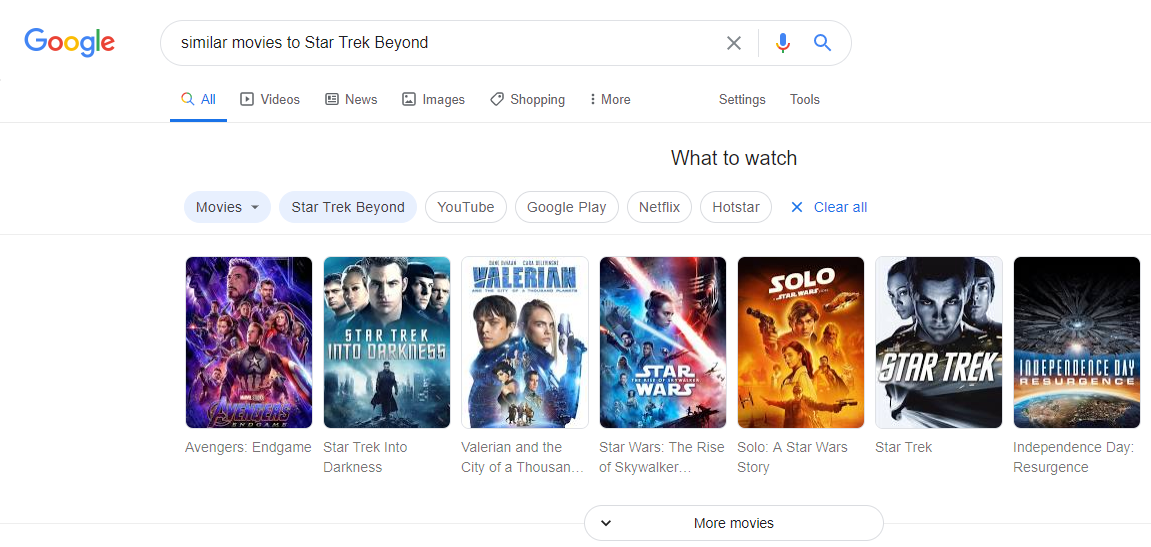<img src="files/test.PNG">